In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time,datetime

from datetime import date,timedelta
import jpholiday

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from pycaret.regression import *

# 厚生労働省のHPからCSVをDL

In [3]:
positive = 'https://www.mhlw.go.jp/content/pcr_positive_daily.csv'
pcr_test = 'https://www.mhlw.go.jp/content/pcr_tested_daily.csv'
toei = pd.read_csv('./csv/toei_20201101.csv')
temp = pd.read_csv('./csv/data.csv',encoding="shift-jis",header=2)
temp = temp.iloc[1:,[0,1,4]] #余計な行列を削除

pos = pd.read_csv(positive)
pcr = pd.read_csv(pcr_test)

pos.columns = ['Date','Positive']
pcr.columns = ['Date','Test']
toei.columns = ['Date','TrainRate']
temp.columns = ['Date','Humidity','Temparature']

pos['Date'] = pd.to_datetime(pos['Date'])
pcr['Date'] = pd.to_datetime(pcr['Date'])
toei['Date'] = pd.to_datetime(toei['Date'])
temp['Date'] = pd.to_datetime(temp['Date'])

pos = pos.set_index('Date')
pcr = pcr.set_index('Date')
toei = toei.set_index('Date')
temp = temp.set_index('Date')

df = pd.concat([pos,pcr],axis=1)
df = pd.concat([df,toei],axis=1)
df = pd.concat([df,temp],axis=1)

# 乗車率の欠損値補完
# 祝日・曜日フラグ

In [4]:
df2 = df.copy()
df2.TrainRate=df2.TrainRate.interpolate()
df2.fillna(0,inplace=True)

df2['is_holiday'] = df2.index.map(jpholiday.is_holiday).astype(int)
df2['dayofweek'] = df2.index.dayofweek


# 60日前のラグ特徴量作成

In [5]:
df3 = df2.copy()
df3['Date'] = df3.index + timedelta(days=60)
df3 = df3.set_index('Date')
df3.columns = ['Positive_lag60','Test_lag60','TrainRate_lag60','Humidity_lag60',
              'Temparature_lag60','is_holiday_lag60','dayofweek_lag60']

df3['Positive']= df2['Positive']
df3 =df3.fillna(0)

# StandardScalerでグラフ描画

In [6]:
scaler = StandardScaler()
df4 = scaler.fit_transform(df2)
df4 = pd.DataFrame(df4)
df4.columns = df2.columns
df4.index = df2.index

# pyCaret Regression

In [7]:
X_train = df3.iloc[:-60,:-1]
y_train = df3.iloc[:-60,-1]
X_test = df3.iloc[-60:,:-1]
y_test = df3.iloc[-60:,-1]

In [9]:
exp1 = setup(df3.iloc[:-60,:],'Positive')

,Description,Value
0,session_id,3405
1,Target,Positive
2,Original Data,"(260, 8)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(181, 13)"


In [10]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,114.4139,28723.7062,165.5070,0.8112,0.6113,0.6843,0.7920
xgboost,Extreme Gradient Boosting,110.9080,29872.1989,166.3811,0.8076,0.5088,0.5138,0.1620
gbr,Gradient Boosting Regressor,120.9896,31103.6464,170.1795,0.8001,0.6161,0.6434,0.0140
rf,Random Forest Regressor,125.0703,33862.6789,175.6559,0.7844,0.5419,0.5890,0.1580
et,Extra Trees Regressor,125.9069,35235.1346,180.6618,0.7722,0.6128,0.7370,0.1540
lightgbm,Light Gradient Boosting Machine,134.2860,34975.6627,182.2083,0.7705,0.8086,0.7897,0.0110
ada,AdaBoost Regressor,159.9306,43007.4623,202.9739,0.7228,0.8501,1.3152,0.0250
dt,Decision Tree Regressor,130.4038,43509.0389,197.8556,0.6952,0.5810,0.6326,0.0100
llar,Lasso Least Angle Regression,215.8845,82363.8280,281.1997,0.4556,0.9635,1.4934,0.0070
en,Elastic Net,214.1278,81867.9527,280.8296,0.4522,1.0070,1.4746,0.0060


In [31]:
cat = create_model('catboost')
xgb = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,151.8161,58407.4531,241.6763,0.6954,0.5544,0.3930
1,103.9755,16605.3477,128.8617,0.9205,0.7400,0.9930
2,114.2841,23690.0039,153.9156,0.8548,0.4571,0.4425
3,71.4106,11670.4834,108.0300,0.8992,0.6452,0.8221
4,97.9176,19827.9434,140.8117,0.7944,0.2596,0.1902
5,115.2143,50892.6406,225.5940,0.7697,0.4407,0.3599
6,79.1440,12787.8047,113.0832,0.8804,0.5022,0.5318
7,92.9131,27798.0898,166.7276,0.7958,0.2937,0.2289
8,170.0490,53152.6211,230.5485,0.7123,0.6797,0.8356
9,112.3554,23889.6016,154.5626,0.7540,0.5154,0.3405


In [32]:
tuned_cat = tune_model(cat)
tuned_xgb = tune_model(xgb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,149.8738,48198.6953,219.5420,0.7487,0.3663,0.3132
1,116.5632,19312.4453,138.9692,0.9076,0.7942,1.0212
2,151.5018,40195.6367,200.4885,0.7536,0.6270,0.7500
3,96.2698,27426.8750,165.6106,0.7630,0.7283,0.8656
4,105.0546,17503.6953,132.3015,0.8185,0.4142,0.3214
5,113.1956,24842.2480,157.6142,0.8876,1.1194,0.5620
6,75.1661,11389.6973,106.7225,0.8935,0.6291,0.7572
7,96.5702,21143.8750,145.4093,0.8447,0.5496,0.5612
8,158.4126,54013.3398,232.4077,0.7076,0.6146,0.7337
9,96.7875,15344.1113,123.8714,0.8420,0.7300,0.5568


In [33]:
ensemble = blend_models([cat,xgb])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,147.2782,50646.3547,225.0474,0.7359,0.5090,0.4244
1,89.8311,14284.9561,119.5197,0.9316,0.7743,1.0122
2,116.6257,22774.0492,150.9107,0.8604,0.4733,0.4830
3,72.3478,12005.4460,109.5694,0.8963,0.6166,0.7633
4,100.8503,19913.9123,141.1167,0.7935,0.3113,0.2530
5,116.7349,42458.2311,206.0540,0.8079,0.5167,0.5091
6,80.1954,10416.3982,102.0608,0.9026,0.6758,0.8688
7,87.4669,27708.5120,166.4587,0.7965,0.3500,0.3052
8,148.1939,49669.5051,222.8666,0.7311,0.6068,0.6993
9,113.5568,21505.1715,146.6464,0.7786,0.5891,0.4505


In [34]:
stacking = stack_models(estimator_list = [cat],meta_model = xgb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,121.6217,43400.0078,208.3267,0.7737,0.4053,0.3302
1,98.0655,18431.6758,135.7633,0.9118,0.5682,0.6490
2,145.5732,43591.6094,208.7860,0.7328,0.6169,0.4716
3,83.1475,13151.8232,114.6814,0.8864,0.4418,0.4379
4,98.9663,23246.5605,152.4682,0.7589,0.2742,0.2332
5,117.3268,38726.4062,196.7903,0.8248,0.3553,0.3037
6,105.6478,20681.7734,143.8116,0.8066,0.8702,1.1342
7,77.6065,15312.8789,123.7452,0.8875,0.2319,0.2064
8,157.0816,48605.2969,220.4661,0.7369,0.6350,0.6790
9,129.3320,31515.1875,177.5252,0.6755,0.4829,0.3997


In [35]:
#plot_model(tuned_cat)

In [36]:
#interpret_model(tuned_cat)

In [37]:
cat_predicted = predict_model(tuned_cat)
ens_predicted = predict_model(ensemble)
stack_predicted = predict_model(stacking)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,140.5233,41399.1764,203.4679,0.7797,0.7683,1.0814


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,106.3008,28169.3758,167.8373,0.8501,0.5544,0.5934


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,114.6627,30426.9277,174.4332,0.8381,0.6456,0.7278


In [38]:
cat_pred = predict_model(tuned_cat,data=df3)
ens_pred = predict_model(ensemble,data=df3)
stack_pred = predict_model(stacking,data=df3)

In [22]:
cat_pred

,Positive_lag60,Test_lag60,TrainRate_lag60,Humidity_lag60,Temparature_lag60,is_holiday_lag60,dayofweek_lag60,Positive,Label
Date,,,,,,,,,
2020-03-01,0.0,0.0,0.00,49.0,5.5,1,2,15.0,177.277820
2020-03-02,0.0,0.0,0.00,60.0,6.2,0,3,14.0,98.705021
2020-03-03,0.0,0.0,0.00,63.0,6.1,0,4,16.0,111.873601
2020-03-04,0.0,0.0,0.00,53.0,7.2,0,5,33.0,119.622358
2020-03-05,0.0,0.0,0.00,61.0,5.4,0,6,31.0,111.873601
...,...,...,...,...,...,...,...,...,...
2021-01-10,1535.0,33681.0,-30.34,48.0,11.9,0,2,0.0,142.542731
2021-01-11,1623.0,29912.0,-30.34,63.0,10.2,0,3,0.0,173.511759
2021-01-12,1704.0,24038.0,-30.34,67.0,13.7,0,4,0.0,145.143637


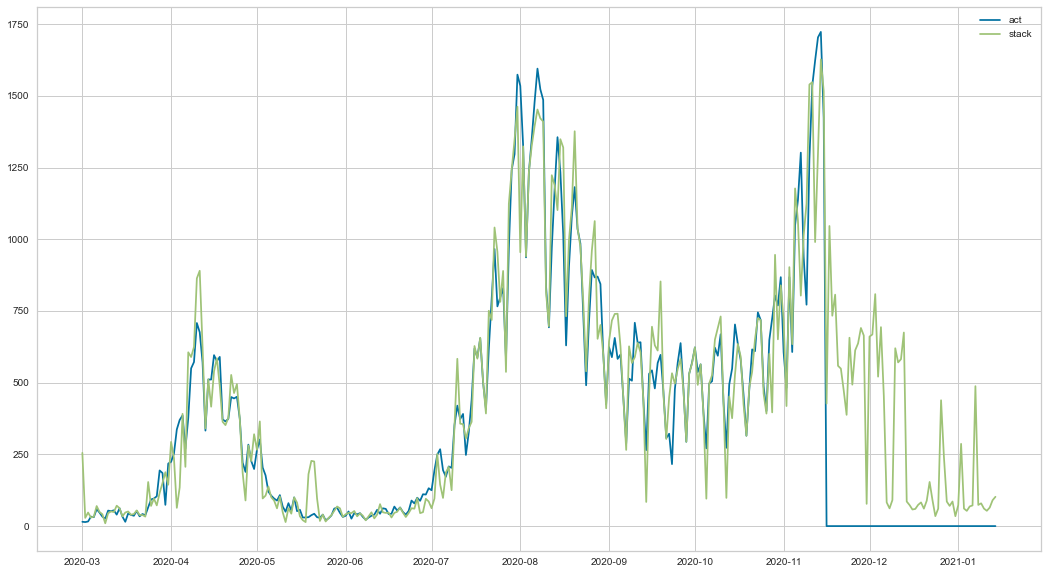

In [54]:
plt.figure(figsize=(18,10))
plt.plot(cat_pred['Positive'],label='act')
#plt.plot(cat_pred['Label'],label='cat')
#plt.plot(ens_pred['Label'],label ='ens')
plt.plot(stack_pred['Label'],label='stack')
plt.legend()
#plt.savefig('./fig/model02_pycaret_20201116.png')